In [1]:
%pylab inline
import gc
import galsim
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sympy
from sympy.series import series
x,y,a,b = sympy.var('x,y,a,b')
expr=(a+y)**2*(b+x)/(1+x)**3
expr.series(x,x0=0,n=3).removeO().series(y,x0=0,n=3).removeO()

6*a**2*b*x**2 - 3*a**2*b*x + a**2*b - 3*a**2*x**2 + a**2*x + y**2*(6*b*x**2 - 3*b*x + b - 3*x**2 + x) + y*(12*a*b*x**2 - 6*a*b*x + 2*a*b - 6*a*x**2 + 2*a*x)

In [3]:
x,y,a,b = sympy.var('x,y,a,b')
expr=(a+y)**2/(1+x)**2
expr.series(x,x0=0,n=3).removeO().series(y,x0=0,n=3).removeO()

3*a**2*x**2 - 2*a**2*x + a**2 + y**2*(3*x**2 - 2*x + 1) + y*(6*a*x**2 - 4*a*x + 2*a)

In [4]:
x,y,a,b = sympy.var('x,y,a,b')
expr=(a+x)**2/(1+x)**2
expr.series(x,x0=0,n=3).removeO()

a**2 + x**2*(3*a**2 - 4*a + 1) + x*(-2*a**2 + 2*a)

In [5]:
x,y,a,b = sympy.var('x,y,a,b')
expr=(a+x)*(b+y)/(1+x)**2
expr.series(x,x0=0,n=3).removeO().series(y,x0=0,n=3).removeO()

3*a*b*x**2 - 2*a*b*x + a*b - 2*b*x**2 + b*x + y*(3*a*x**2 - 2*a*x + a - 2*x**2 + x)

In [6]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


+ corrections for ellipticity, response and flux ratio 

$\frac{x}{1+x}=x-x^2$

$\frac{y}{1+x}=y(1-x)$

$\frac{a}{1+x}=a(1-x+x^2)$

$\frac{a^2}{(1+x)^2}=a^2(1-2x+3x^2)$

$\frac{(a+y)^2}{(1+x)^2}=a^2(1-2x+3x^2)+y^2+2ay(1-2x)$

$\frac{(a+y)^2(b+x)}{(1+x)^3}=(a+y)^2(b+x)(1-3x+6x^2)$

$(a^2b+2aby+by^2+a^2x+2axy+xy^2)(1-3x+6x^2)$


$a^2b(1+6x^2)+2aby(1-3x)+a^2x(1-3x)+by^2+2axy$


$a^2b(1+6x^2)-3a^2x^2+by^2+2a(1-3b)xy$


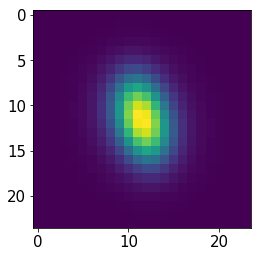

In [7]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
psfFWHM=0.60
scale=0.168
igal=42
beta=0.75

hsmCat=pyfits.getdata('galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
rcut=rcutArray[igal]
    
beg=ngrid//2-rcut
end=beg+2*rcut
galImgAll=pyfits.getdata('galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
img=galImgAll[igal//nx*ngrid+beg:igal//nx*ngrid+end,igal%nx*ngrid+beg:igal%nx*ngrid+end]/10.
plt.imshow(img)

In [8]:
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
fpTask0=fpfsBase.fpfsTask(psfData,beta=beta)

a0=fpTask0.measure(img)
C=1000
b0=fpfsBase.fpfsM2E(a0,C)
print(a0,a0.dtype.names)
print(b0,b0.dtype.names)

(12.53078177, 3.20816112, -1.90802405, 1.47132046) ('fpfs_M00', 'fpfs_M22c', 'fpfs_M22s', 'fpfs_M40')
[(0.00316846, -0.00188441, 0.00773305, 0.0123757, 1.35901297e-05, 9.4907464e-06)] ('fpfs_e1', 'fpfs_e2', 'fpfs_RE', 'fpfs_s0', 'fpfs_eSquare', 'fpfs_RS')


In [9]:
# Noise
corPre      =   'corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
variance    =   8e-3
ngrid=64

if False:
    corIn=pyfits.getdata(corFname)*variance
    corIn=np.pad(corIn,(23-32+rcut,22-32+rcut))

    corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones(img.shape)))**2.)).real
    corIn=corIn*corNum
    powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
else:
    powIn=np.load('corPre/noiPows2.npy',allow_pickle=True).item()['%s'%rcut]*variance*100
powModel=np.zeros((1,img.shape[0],img.shape[1]))
powModel[0]=powIn
#fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0],beta=beta)

In [10]:
%%time

import numpy.lib.recfunctions as rfn
a=[]
for j in range(0,40):
    noiAll=pyfits.getdata('noise/noi%04d.fits' %j)*np.sqrt(variance*100.)
    imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(ngal)]
    #plt.imshow(imgList[5])
    res=fpTask.measure(imgList)
    a.append(res)
    del noiAll,imgList
    gc.collect()
a =   rfn.stack_arrays(a,usemask=False)

CPU times: user 3min 33s, sys: 14.6 s, total: 3min 47s
Wall time: 3min 48s


## Test1: shapelet modes covariance

In [11]:
print('variance of N00 from simulation and equation:')
print(np.var(a['fpfs_M00']),np.average(a['fpfs_N00N00']))
print('variance of N40 from simulation and equation:')
print(np.var(a['fpfs_M40']),np.average(a['fpfs_N40N40']))
print('variance of N22c from simulation and equation:')
print(np.var(a['fpfs_M22c']),np.average(a['fpfs_N22cN22c']))
print('variance of N22s from simulation and equation:')
print(np.var(a['fpfs_M22s']),np.average(a['fpfs_N22sN22s']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22c']*a['fpfs_M00'])-np.average(a['fpfs_M22c'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22c']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22s']*a['fpfs_M00'])-np.average(a['fpfs_M22s'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22s']))
print('cov of N40N00 from simulation and equation:')
print(np.average(a['fpfs_M40']*a['fpfs_M00'])-np.average(a['fpfs_M40'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N40']))

variance of N00 from simulation and equation:
418.20833666336836 419.05625779699847
variance of N40 from simulation and equation:
25318.943471736173 25295.271920488845
variance of N22c from simulation and equation:
1240.1099677434004 1235.363643513283
variance of N22s from simulation and equation:
1226.9997919772616 1219.9856915316414
cov of N22cN00 from simulation and equation:
50.14818872689406 47.735687760569014
cov of N22cN00 from simulation and equation:
-35.4586392618787 -35.39497052352448
cov of N40N00 from simulation and equation:
740.5903961784259 744.8122473466215


In [12]:
b=fpfsBase.fpfsM2E(a,C)

In [13]:
print('Discrepancy in ellipticities and Response')
print('e1:',np.average(b['fpfs_e1'])-np.average(b0['fpfs_e1']))
print('e2:',np.average(b['fpfs_e2'])-np.average(b0['fpfs_e2']))
print('esq1:',np.average(b['fpfs_e1']**2.)-np.average(b0['fpfs_e1']**2.))
print('esq2:',np.average(b['fpfs_e2']**2.)-np.average(b0['fpfs_e2']**2.))
print('ssq0:',np.average(b['fpfs_s0']**2.)-np.average(b0['fpfs_s0']**2.))
print('s0:',np.average(a['fpfs_M00']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print('s4:',np.average(a['fpfs_M40']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print('RE:',np.average(b['fpfs_RE'])-np.average(b0['fpfs_RE']))
print('e1sqS:',np.average(b['fpfs_e1']**2.*(a['fpfs_M00']/(a['fpfs_M00']+C)))-np.average(b0['fpfs_e1']**2.*(a0['fpfs_M00']/(a0['fpfs_M00']+C))))
print('e2sqS:',np.average(b['fpfs_e2']**2.*(a['fpfs_M00']/(a['fpfs_M00']+C)))-np.average(b0['fpfs_e2']**2.*(a0['fpfs_M00']/(a0['fpfs_M00']+C))))

Discrepancy in ellipticities and Response
e1: 6.08550448670149e-05
e2: 7.448101276735894e-05
esq1: 0.001198060157484226
esq2: 0.0011851767189961595
ssq0: 0.0003824631603258491
s0: -0.0003607413129871218
s4: -0.0002683194520261981
RE: 0.001619850831917775
e1sqS: 2.0058313432842374e-05
e2sqS: 1.955052360645987e-05


In [14]:
# e
ratio=a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.
e1=np.average((b['fpfs_e1']+a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1+ratio))
e2=np.average((b['fpfs_e2']+a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1+ratio))
print(e1-np.average(b0['fpfs_e1']),e1/np.average(b0['fpfs_e1'])-1)
print(e2-np.average(b0['fpfs_e2']),e2/np.average(b0['fpfs_e2'])-1)

0.00010495342329080223 0.03312444972577899
4.146034563974545e-05 -0.02200175425516726


In [15]:
e1sq=np.average((b['fpfs_e1']**2.-a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e1']*a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
e2sq=np.average((b['fpfs_e2']**2.-a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e2']*a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
print(e1sq-np.average(b0['fpfs_e1']**2.),e1sq/np.average(b0['fpfs_e1']**2.)-1)
print(e2sq-np.average(b0['fpfs_e2']**2.),e2sq/np.average(b0['fpfs_e2']**2.)-1)

2.8958937940573316e-05 2.884607694722366
2.9357387279560726e-05 8.267347346523197


In [16]:
#s0 s4
s0=np.average((a['fpfs_M00']/(a['fpfs_M00']+C)+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)/(1+ratio))
s4=np.average((a['fpfs_M40']/(a['fpfs_M00']+C)+a['fpfs_N00N40']/(a['fpfs_M00']+C)**2.)/(1+ratio))
RE=(s0-s4+e1sq+e2sq)/np.sqrt(2.)
print(s0-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(s4-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print(RE-np.average(b0['fpfs_RE']))

3.34719246758014e-05
0.000455085174992009
-0.0002568897193196539


In [17]:
print(e1/RE-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(e2/RE-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

0.028117205107472343
-0.0028275555785594875


In [18]:
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

-0.06445546751248854
0.050167410933557255


$a^2b(1+6x^2)-3a^2x^2+by^2+2a(1-3b)xy$

In [19]:
tmp=a['fpfs_M00']/(a['fpfs_M00']+C)
e1sqS=b['fpfs_e1']**2.*tmp+3.*b['fpfs_e1']**2.*a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.-tmp*a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.
e1sqS=np.average(e1sqS/(1+6.*ratio))
e2sqS=b['fpfs_e2']**2.*tmp+3.*b['fpfs_e2']**2.*a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.-tmp*a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.
e2sqS=np.average(e2sqS/(1+6.*ratio))
print(e1sqS-np.average(b0['fpfs_e1']**2.*a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(e2sqS-np.average(b0['fpfs_e2']**2.*a0['fpfs_M00']/(a0['fpfs_M00']+C)))

2.1738292846864937e-06
2.0167664463535307e-06


In [20]:
def fpfsM2E(moments,const=1.,mcalib=0.,rev=False):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of FPFS ellipticities,
                FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response
    """
    #Get weight
    weight  =   moments['fpfs_M00']+const
    #Ellipticity
    e1      =   moments['fpfs_M22c']/weight
    e2      =   moments['fpfs_M22s']/weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']/weight
    s4      =   moments['fpfs_M40']/weight
    #FPFS sel Respose (part1)
    e1sqS0  =   e1sq*s0
    e2sqS0  =   e2sq*s0

    if rev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        assert 'fpfs_N00N40' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']/weight**2.
        
        e1sqS0= (e1sqS0+3.*e1sq*moments['fpfs_N00N00']/weight**2.\
                -s0*moments['fpfs_N22cN22c']/weight**2.)/(1+6.*ratio)
        e2sqS0= (e2sqS0+3.*e2sq*moments['fpfs_N00N00']/weight**2.\
                -s0*moments['fpfs_N22sN22s']/weight**2.)/(1+6.*ratio)
        
        e1  =   (e1+moments['fpfs_N00N22c']\
                /weight**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                /weight**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']/weight**2.\
                +4.*e1*moments['fpfs_N00N22c']/weight**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']/weight**2.\
                +4.*e2*moments['fpfs_N00N22s']/weight**2.)\
                /(1.+3*ratio)
        s0Sq=  (s0**2.-moments['fpfs_N00N00']/weight**2.\
                +4.*s0*moments['fpfs_N00N00']/weight**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                /weight**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                /weight**2.)/(1+ratio)


    eSq     =   e1sq+e2sq
    eSqS0   =   e1sqS0+e2sqS0
    #Response factor
    RE      =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    types   =   [('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RE','>f8'),\
                ('fpfs_s0','>f8'), ('fpfs_eSquare','>f8'), ('fpfs_s0Square','>f8'), \
                ('fpfs_RS','>f8')]
    ellDat  =   np.array(np.zeros(moments.size),dtype=types)
    ellDat['fpfs_e1']   =   e1
    ellDat['fpfs_e2']   =   e2
    ellDat['fpfs_RE']   =   RE
    ellDat['fpfs_s0']   =   s0
    ellDat['fpfs_eSquare']  =   eSq
    ellDat['fpfs_s0Square']  =   s0Sq
    ellDat['fpfs_RS']   =   (eSq-eSqS0)/np.sqrt(2.)
    return ellDat

def fpfsM2Err(moments,const=1.):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of measurement error for,
                FPFS ellipticity,
                FPFS flux ratio 
    """
    assert 'fpfs_N00N00' in moments.dtype.names
    assert 'fpfs_N00N22c' in moments.dtype.names
    assert 'fpfs_N00N22s' in moments.dtype.names
    assert 'fpfs_N00N40' in moments.dtype.names
    
    #Get weight
    weight  =   moments['fpfs_M00']+const
    #FPFS Ellipticity
    e1      =   moments['fpfs_M22c']/weight
    e2      =   moments['fpfs_M22s']/weight
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']/weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    s0sq    =   s0*s0
    ratio   =   moments['fpfs_N00N00']/weight**2.
    
    e1Err    =   moments['fpfs_N22cN22c']/weight**2.\
            -4.*e1*moments['fpfs_N00N22c']/weight**2.\
            +3*ratio*e1sq
    e2Err    =   moments['fpfs_N22sN22s']/weight**2.\
            -4.*e2*moments['fpfs_N00N22s']/weight**2.\
            +3*ratio*e2sq
    s0Err    =   moments['fpfs_N00N00']/weight**2.\
            -4.*s0*moments['fpfs_N00N00']/weight**2.\
             +3*ratio*s0sq
    
    e1s0Cov =   moments['fpfs_N00N22c']/weight**2.\
            -2.*s0*moments['fpfs_N00N22c']/weight**2.\
            -2.*e1*moments['fpfs_N00N00']/weight**2.\
            +3*ratio*e1*s0
    
    e2s0Cov =   moments['fpfs_N00N22s']/weight**2.\
            -2.*s0*moments['fpfs_N00N22s']/weight**2.\
            -2.*e2*moments['fpfs_N00N00']/weight**2.\
            +3*ratio*e2*s0

    types   =   [('fpfs_e1Err','>f8'),('fpfs_e2Err','>f8'),('fpfs_s0Err','>f8'),\
                    ('fpfs_e1s0Cov','>f8'),('fpfs_e2s0Cov','>f8')]
    ellDat  =   np.array(np.zeros(moments.size),dtype=types)
    ellDat['fpfs_e1Err']   =   e1Err
    ellDat['fpfs_e2Err']   =   e2Err
    ellDat['fpfs_s0Err']   =   s0Err
    ellDat['fpfs_e1s0Cov'] =   e1s0Cov
    ellDat['fpfs_e2s0Cov'] =   e2s0Cov
    return ellDat

b2=fpfsM2E(a,C,rev=True)
bErr2=fpfsM2Err(a,C)

## Test2: average revision

In [21]:
print(np.average(b2['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b2['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b2['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b2['fpfs_s0']-b0['fpfs_s0']))
print(np.average(b2['fpfs_e1'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b2['fpfs_e2'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))
print(np.average(b2['fpfs_eSquare'])-np.average(b0['fpfs_eSquare']))
print(np.average(b2['fpfs_s0Square'])-np.average(b0['fpfs_s0']**2.))
print(np.average(b2['fpfs_RS'])-np.average(b0['fpfs_RS']))

0.00010495342329080154
4.146034563974414e-05
-0.00025667178917088916
3.3471924675803475e-05
0.028104442243594818
-0.0028203700082052585
5.86245249921643e-05
1.1307764871056633e-05
3.849060050716978e-05


In [22]:
print(np.average(b['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b['fpfs_s0']-b0['fpfs_s0']))
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_eSquare'])-np.average(b0['fpfs_eSquare']))
print(np.average(b['fpfs_RS'])-np.average(b0['fpfs_RS']))

6.08550448670137e-05
7.448101276735803e-05
0.0016198508319177772
-0.00036074131298712464
-0.06445546751248854
0.050167410933557255
0.0023832368764803865
0.0016571952792677233


## Test3: Measurement error

In [ ]:
print(np.var(b['fpfs_e1']-b0['fpfs_e1']),np.average(bErr2['fpfs_e1Err']))
print(np.var(b['fpfs_e2']-b0['fpfs_e2']),np.average(bErr2['fpfs_e2Err']))
print(np.var(b['fpfs_s0']-b0['fpfs_s0']),np.average(bErr2['fpfs_s0Err']))
print(np.average((b['fpfs_s0']-b0['fpfs_s0'])*(b['fpfs_e1']-b0['fpfs_e1'])),np.average(bErr2['fpfs_e1s0Cov']))
print(np.average((b['fpfs_s0']-b0['fpfs_s0'])*(b['fpfs_e2']-b0['fpfs_e2'])),np.average(bErr2['fpfs_e2s0Cov']))

0.0003912618818260021


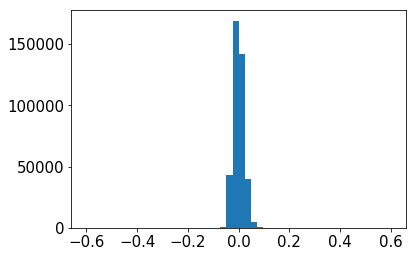

In [24]:
plt.hist(b['fpfs_s0']-b0['fpfs_s0'],range=(-0.6,0.6),bins=50)
print(np.var(b['fpfs_s0']-b0['fpfs_s0']))

0.00039695889021213257


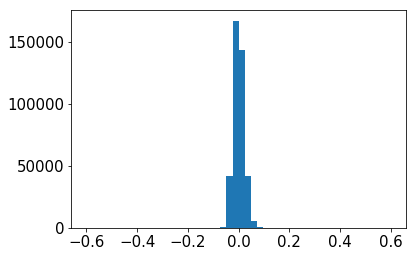

In [25]:
plt.hist(b2['fpfs_s0']-b0['fpfs_s0'],range=(-0.6,0.6),bins=50)
print(np.var(b2['fpfs_s0']-b0['fpfs_s0']))

0.0011976708208565501


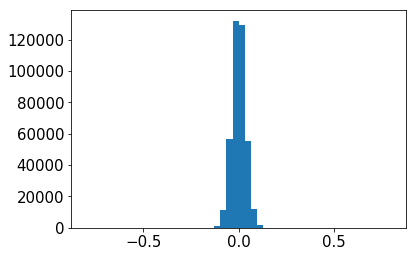

In [26]:
_=plt.hist(b['fpfs_e1']-b0['fpfs_e1'],range=(-0.8,0.8),bins=50)
print(np.var(b['fpfs_e1']-b0['fpfs_e1']))

0.0012088647980896638


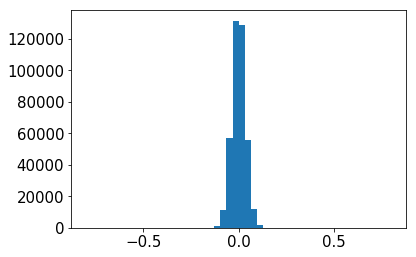

In [27]:
plt.hist(b2['fpfs_e1']-b0['fpfs_e1'],range=(-0.8,0.8),bins=50)
print(np.var(b2['fpfs_e1']-b0['fpfs_e1']))